# Simulating Dickey–Fuller distributions

In [17]:
library(tidyverse)
library(dynlm)
library(car) 

options(repr.plot.width=8, repr.plot.height=3)

# Simulations
First number of simulations should be set sufficiently high, this should be several thousand since we're not estimating the mean but the upper and lower quantiles. This is computationally heavy and therefore start with 1000, which should be <5 min. 

Sample size should be set according to the dataset
$$
\begin{aligned}
\Delta y_t = a_0 + \gamma y_{t-1} + a_2t + \varepsilon_t \qquad \qquad
\gamma &= 0 \qquad \tau_1 \\
a_2 = \gamma &= 0 \qquad \phi_3 \\
a_0 = a_2 = \gamma &= 0 \qquad \phi_2 \\
\\
\Delta y_t = a_0 + \gamma y_{t-1} + \varepsilon_t \qquad \qquad
\gamma &= 0 \qquad \tau_2 \\
a_0 = \gamma  &= 0 \qquad \phi_1 \\
\\
\Delta y_t = \gamma y_{t-1} + \varepsilon_t \qquad \qquad
\gamma &= 0 \qquad \tau_3 \\
\end{aligned}
$$

In [50]:
nsim <- 1000
nsample <- 100

subt <- paste(nsim, "simulations  -", nsample,"samples in each") # for use in plotting

### $\tau_1$ - simulation with gamma, drift and trend

In [19]:
tau1 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    a <- summary(dynlm(x ~ L(x) + seq_along(x)))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau1[i] <- new
}

### $\tau_2$ - simulation with gamma and drift

In [20]:
tau2 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    a <- summary(dynlm(x ~ L(x)))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau2[i] <- new
}

### $\tau_3$ - simulation with gamma

In [21]:
tau3 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    a <- summary(dynlm(x ~ L(x) + 0))
    new <- (a$coefficients["L(x)", "Estimate"] - 1)/a$coefficients["L(x)", "Std. Error"]
    tau3[i] <- new
}

### $\phi_1$ - F-test of gamma and drift = 0 for $\tau_2$ 

In [22]:
phi1 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    reg <- dynlm(x ~ L(x))
    new <- linearHypothesis(reg, c("L(x) = 1", "(Intercept) = 0"), test="F")$F[2]
    phi1[i] <- new
}

### $\phi_2$ - F-test of gamma, drift and trend = 0 for $\tau_1$ 

In [23]:
phi2 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    reg <- dynlm(x ~ L(x) + seq_along(x))
    new <- linearHypothesis(reg, c("L(x) = 1", "seq_along(x) = 0", "(Intercept) = 0"), test="F")$F[2]
    phi2[i] <- new
}

### $\phi_3$ - F-test of gamma and drift = 0 for $\tau_1$ 

In [24]:
phi3 <- NA
for (i in 1:nsim) {
    x <- as.ts(cumsum(rnorm(nsample)))
    reg <- dynlm(x ~ L(x) + seq_along(x))
    new <- linearHypothesis(reg, c("L(x) = 1", "seq_along(x) = 0"), test="F")$F[2]
    phi3[i] <- new
}

# Critical values for Dickey Fuller

In [53]:
zndist <- rnorm(nsim)

ndistq <- quantile(zndist, probs = c(0.01,0.025,0.05))
tau1q <- quantile(tau1, probs = c(0.01,0.025,0.05))
tau2q <- quantile(tau2, probs = c(0.01,0.025,0.05))
tau3q <- quantile(tau3, probs = c(0.01,0.025,0.05))
phi1q <- quantile(phi1, probs = c(0.99,0.975,0.95))
phi2q <- quantile(phi2, probs = c(0.99,0.975,0.95))
phi3q <- quantile(phi3, probs = c(0.99,0.975,0.95))

quantiles <- cbind(tau1q, tau2q, tau3q, ndistq, phi1q, phi2q, phi3q)
colnames(quantiles) = c("Tau 1", "Tau 2", "Tau 3", "Normal Dist", "Phi 1", "Phi 2", "Phi 3")
quantiles

Tau 1     Tau 2     Tau 3     Normal Dist Phi 1    Phi 2    Phi 3   
1%   -4.022319 -3.499848 -2.688977 -2.074484   6.592231 6.569634 8.709823
2.5% -3.731017 -3.181325 -2.371149 -1.837754   5.288349 5.444605 7.489089
5%   -3.482826 -2.904652 -1.991103 -1.480349   4.651711 4.783344 6.401891

# Visualisation of distributions

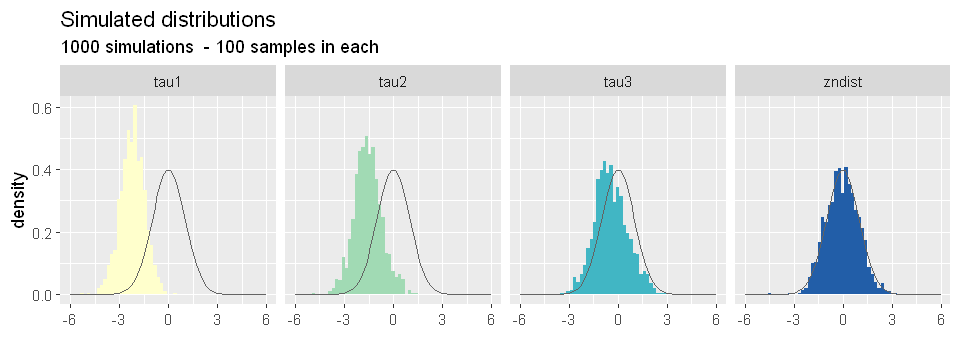

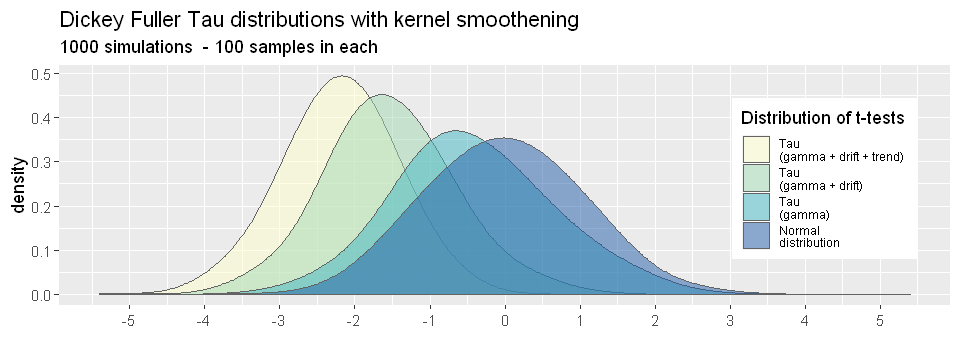

In [51]:
adf <- data.frame(zndist,tau1,tau2,tau3) %>%
  gather(variable, value)

p1 <- ggplot(adf, aes(value, fill=variable)) + 
  geom_histogram(bins=60, aes(y = ..density..)) + 
  scale_fill_brewer(guide=F, palette="YlGnBu") +
  stat_function(fun=dnorm, color="#636363", args=list(mean=0, sd=1)) +
  facet_wrap(~variable, nrow=1) + 
  scale_x_continuous(limits = c(-6, 6)) +
  labs(title="Simulated distributions", subtitle = subt, x="")

df <- data.frame(tau1, tau2, tau3, zndist) %>%
  gather(variable, value)

p2 <- ggplot(df, aes(value, fill=variable)) + 
  geom_density(adjust=2, alpha=0.5, color="#636363") + 
  scale_fill_brewer(name="Distribution of t-tests", 
                    labels = c("Tau\n(gamma + drift + trend)", 
                               "Tau\n(gamma + drift)", 
                               "Tau\n(gamma)",
                               "Normal\ndistribution"), 
                    palette="YlGnBu",
                    direction=1) + 
  labs(title="Dickey Fuller Tau distributions with kernel smoothening", subtitle=subt, x="") + 
  scale_x_continuous(limits = c(-5.4, 5.4), breaks=seq(-5,5,by=1)) +
  theme(legend.text=element_text(size=7),
        legend.justification = c(1, 1), 
        legend.box.margin=margin(c(20,20,50,50)),
        legend.position = c(1, 1))

print(p1) 
print(p2)

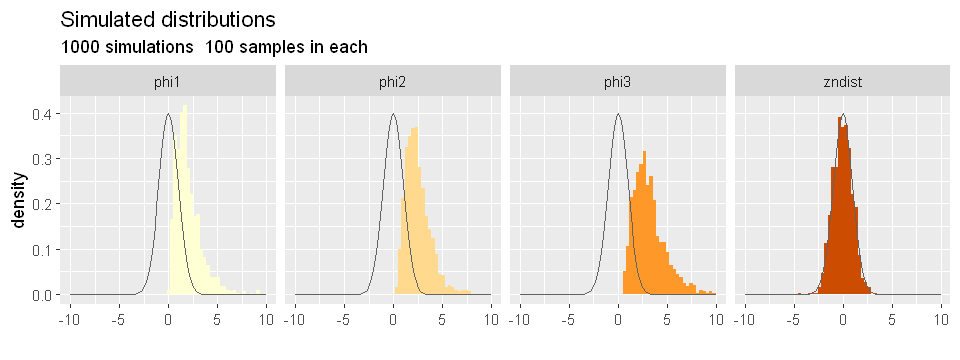

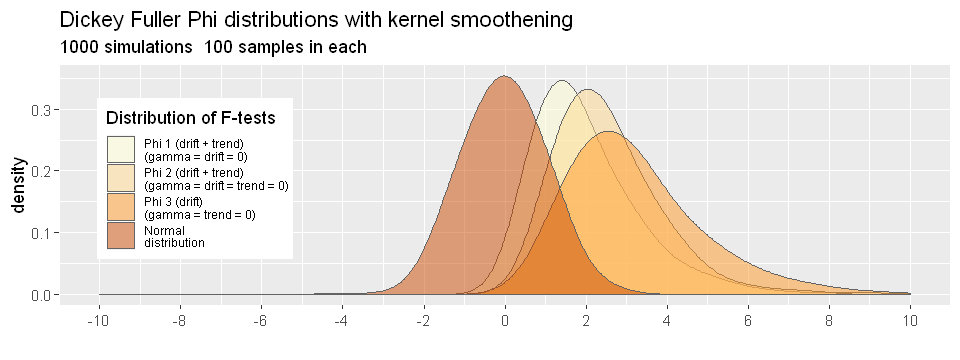

In [47]:
adf <- data.frame(phi1,phi2,phi3, zndist) %>%
  gather(variable, value)

p1 <- ggplot(adf, aes(value, fill=variable)) + 
  geom_histogram(bins=60, aes(y = ..density..)) + 
  scale_fill_brewer(guide=F, palette="YlOrBr") +
  stat_function(fun=dnorm, color="#636363", args=list(mean=0, sd=1)) +
  facet_wrap(~variable, nrow=1) + 
  scale_x_continuous(limits = c(-10, 10)) +
  labs(title="Simulated distributions", subtitle=subt, x="")

df <- data.frame(phi1, phi2, phi3, zndist) %>%
  gather(variable, value)

p2 <- ggplot(df, aes(value, fill=variable)) + 
  geom_density(adjust=2, alpha=0.5, color="#636363") + 
  scale_fill_brewer(name="Distribution of F-tests", 
                    labels = c("Phi 1 (drift + trend)\n(gamma = drift = 0)", 
                               "Phi 2 (drift + trend)\n(gamma = drift = trend = 0)", 
                               "Phi 3 (drift)\n(gamma = trend = 0)",
                               "Normal\ndistribution"), 
                    palette="YlOrBr",
                    direction=1) + 
  labs(title="Dickey Fuller Phi distributions with kernel smoothening", subtitle=subt, x="") + 
  scale_x_continuous(limits = c(-10, 10), breaks=seq(-10,10,by=2)) +
  theme(legend.text=element_text(size=7),
        legend.justification = c(1, 1), 
        legend.box.margin=margin(c(20,20,50,50)),
        legend.position = c(0.3, 1))

suppressWarnings(print(p1))
suppressWarnings(print(p2))

# Simulating with matrix formulas (significaltly faster) (not my code)

In [31]:
T = 100
df <- rep(NA, 10000)

for (i in 1:10000) {
yt <- cumsum(rnorm(T))
X <- cbind(1,yt[-T])
beta <- solve(t(X) %*% X) %*% t(X) %*% yt[-1] 
ssr <- sum((yt[-1] - X %*% beta)^2)
se <- sqrt(ssr / (T-3)) / sqrt(sum((X[,2] - mean(X[,2]))^2))

df[i] <- (beta[2] - 1) / se
}

df %>%
  quantile(probs = c(0.01, 0.025, 0.05)) %>%
  as.data.frame()

.        
1%   -3.545376
2.5% -3.209383
5%   -2.903251